In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.special import roots_legendre
from matplotlib import pyplot as plt
import math
from math import log, exp, sqrt, pi
from scipy.interpolate import interp1d
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

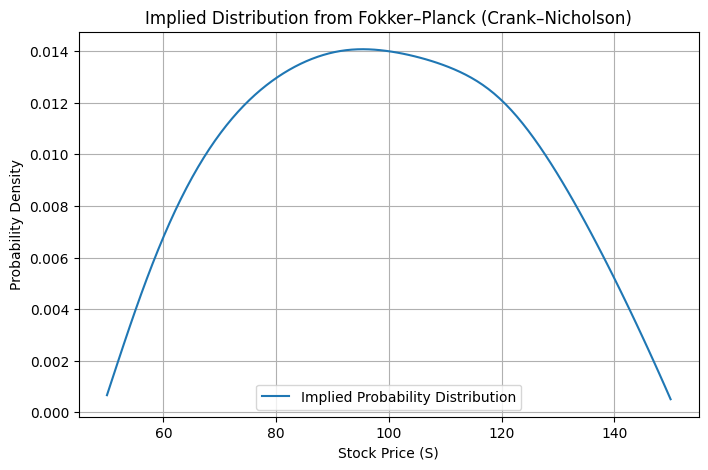

In [12]:
# -------------------------------
# 1. Generate Synthetic Volatility Distributions
# -------------------------------

num_points = 100  # Number of strike prices
strike_prices = np.linspace(50, 150, num_points)  # Define strike range

# Different synthetic volatilities
def constant_volatility(K): return 0.2
def normal_volatility(K): return np.abs(np.random.normal(loc=0.2, scale=0.05))
def poisson_volatility(K): return np.abs((np.random.poisson(lam=3) / 30) + 0.1)
def exponential_volatility(K): return np.random.exponential(scale=0.1)

# Select volatility function
volatility_funcs = {
    "Constant": constant_volatility,
    "Normal": normal_volatility,
    "Poisson": poisson_volatility,
    "Exponential": exponential_volatility
}

# -------------------------------
# 2. Compute Synthetic Option Prices (Black-Scholes)
# -------------------------------

def black_scholes_call(S, K, T, r, sigma):
    """ Black-Scholes formula for a European call option. """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parameters
S0, T, r = 100, 0.5, 0.05  # Underlying price, time to expiry, risk-free rate

# Compute option prices for each volatility type
option_prices = {
    vol_type: np.array([black_scholes_call(S0, K, T, r, volatility_funcs[vol_type](K)) for K in strike_prices])
    for vol_type in volatility_funcs
}

# -------------------------------
# 3. Construct Local Volatility Function
# -------------------------------

# Example K values and sigma(K) from generated volatilities
K_vals = np.linspace(50, 150, 10)  # 10 key strike prices
sigma_K = np.array([volatility_funcs["Normal"](K) for K in K_vals])  # Example normal vol

# Fix extreme values before interpolation
sigma_K = np.clip(sigma_K, 0.05, 0.8)  # Min 5%, max 80%
local_vol_func = interp1d(K_vals, sigma_K, kind="cubic", fill_value="extrapolate")

# -------------------------------
# 4. Define Fokker–Planck Parameters
# -------------------------------

S_min, S_max = 50, 150  # Asset price range
N_S = num_points  # Number of grid points
S_vals = np.linspace(S_min, S_max, N_S)  # Discretized price grid
dS = S_vals[1] - S_vals[0]  # Step size in asset price space

N_T = 50  # Number of time steps
dt = T / N_T  # Time step size

# Compute local volatility at each grid point
sigma_vals = local_vol_func(S_vals)  
sigma_vals = np.clip(sigma_vals, 0.05, 0.8)  # Ensure valid values

# -------------------------------
# 5. Construct Crank–Nicholson Matrices
# -------------------------------

alpha = (r / 2) * S_vals / dS  # Drift term
beta = (sigma_vals**2 * S_vals**2) / (2 * dS**2)  # Diffusion term

A_diag = -beta - alpha / 2
B_diag = -beta + alpha / 2
C_diag = 2 * beta + 1 / dt
D_diag = -2 * beta + 1 / dt

# Create sparse matrices
A = diags([A_diag[1:], C_diag, B_diag[:-1]], [-1, 0, 1], format="csr")  # Left matrix
B = diags([-A_diag[1:], D_diag, -B_diag[:-1]], [-1, 0, 1], format="csr")  # Right matrix

# -------------------------------
# 6. Initialize Probability Distribution
# -------------------------------
pdf = np.exp(-((S_vals - S0) ** 2) / (2 * 200 ** 2))  # Gaussian initial guess
pdf /= np.sum(pdf * dS)  # Normalize to ensure total probability is 1

# -------------------------------
# 7. Solve the Fokker–Planck PDE Using Crank–Nicholson
# -------------------------------
for _ in range(N_T):
    b = B @ pdf  # Compute right-hand side
    pdf = spsolve(A, b)  # Solve linear system

# Normalize final probability distribution
pdf /= np.sum(pdf * dS)

# -------------------------------
# 8. Plot the Final Implied Probability Distribution
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S_vals, pdf, label="Implied Probability Distribution")
plt.xlabel("Stock Price (S)")
plt.ylabel("Probability Density")
plt.title("Implied Distribution from Fokker–Planck (Crank–Nicholson)")
plt.legend()
plt.grid(True)
plt.show()

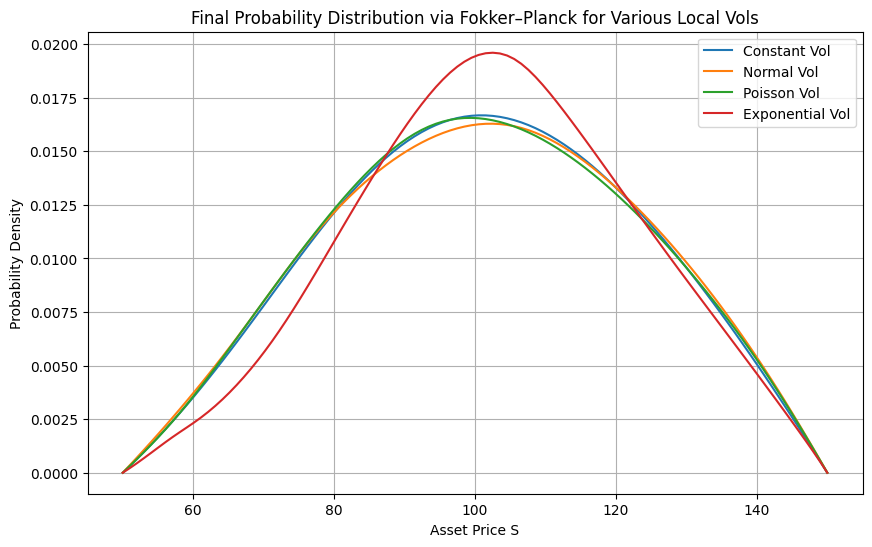

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

# ------------------------------------------------------
# 1. Generate Synthetic Volatility Distributions
# ------------------------------------------------------
num_points = 100  # Number of strike prices
strike_prices = np.linspace(50, 150, num_points)  # Define strike range

# Synthetic volatility functions
def constant_volatility(K):   return 0.2
def normal_volatility(K):     return np.abs(np.random.normal(loc=0.2, scale=0.05))
def poisson_volatility(K):    return np.abs((np.random.poisson(lam=3) / 30) + 0.1)
def exponential_volatility(K):return np.random.exponential(scale=0.1)

# Dictionary of vol functions
volatility_funcs = {
    "Constant":    constant_volatility,
    "Normal":      normal_volatility,
    "Poisson":     poisson_volatility,
    "Exponential": exponential_volatility
}

# ------------------------------------------------------
# 2. Compute Synthetic Option Prices (Black-Scholes)
# ------------------------------------------------------
def black_scholes_call(S, K, T, r, sigma):
    """Black-Scholes formula for a European call option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parameters
S0, T, r = 100, 0.5, 0.05  # Underlying price, time to expiry, risk-free rate

# Compute option prices for each volatility type
option_prices = {
    vol_type: np.array([black_scholes_call(S0, K, T, r, volatility_funcs[vol_type](K))
                        for K in strike_prices])
    for vol_type in volatility_funcs
}

# ------------------------------------------------------
# 3. Set Up Fokker–Planck Solver in S-space
#    (Crank–Nicholson with local volatility)
# ------------------------------------------------------

def fokker_planck_crank_nicolson(S_range, T, r, local_vol_func, N_S=100, N_t=50):
    """
    Solve the forward Fokker–Planck PDE in S-space, i.e.:
        ∂p/∂t = -∂[r S p]/∂S + 0.5 ∂²[σ(S)^2 * S^2 * p]/∂S²
    using a simple Crank–Nicholson scheme.

    Returns:
        (S_vals, pdf): the final distribution pdf(S, t=T).
    """
    S_min, S_max = S_range
    S_vals = np.linspace(S_min, S_max, N_S)
    dS = S_vals[1] - S_vals[0]
    
    dt = T / N_t
    
    # 1. Evaluate local volatility at each grid point
    sigma_vals = local_vol_func(S_vals)
    # Ensure valid numeric range
    sigma_vals = np.clip(sigma_vals, 0.01, 1.0)
    
    # 2. Construct drift and diffusion coefficients
    #    PDE: ∂p/∂t = -∂(r S p)/∂S + 0.5 * ∂²((σ(S)*S)² * p)/∂S²
    alpha = 0.5 * r * S_vals / dS
    beta  = 0.5 * sigma_vals**2 * (S_vals**2) / (dS**2)
    
    # 3. Build tri-di coefficients for Crank–Nicholson
    # Diagonal terms – watch indexing carefully
    # We'll use the usual approach:
    #   L pᶰ = - [ betaᵢ₊₁₋₁ - alphaᵢ - ... ]
    # For simplicity, define the main ones as in your code:
    
    # For i = 0..N_S-1:
    #   lower diag ~ - (beta - alpha/2)  (shifting indexing carefully)
    #   diag       ~ ...
    #   upper diag ~ ...
    # Then we combine into (A, B) = (I - θdtL, I + (1-θ)dtL).
    
    # But to keep consistency with your code style:
    A_diag = -beta - alpha / 2
    B_diag = -beta + alpha / 2
    C_diag = 2 * beta + 1 / dt
    D_diag = -2 * beta + 1 / dt
    
    # Build the sparse matrices
    # Note: these have dimension N_S x N_S, but we must handle boundaries
    A = diags([A_diag[1:], C_diag, B_diag[:-1]],
              offsets=[-1, 0, 1], shape=(N_S, N_S), format="csr")
    B = diags([-A_diag[1:], D_diag, -B_diag[:-1]],
              offsets=[-1, 0, 1], shape=(N_S, N_S), format="csr")
    
    # 4. Set boundary rows to enforce p=0 at boundaries
    #    (or any suitable condition, e.g. reflection or absorbing).
    #    Here, we zero out the row and set diagonal=1 => pdf=0 at boundary:
    for mat in (A, B):
        # First row
        mat[0, 0] = 1.0
        mat[0, 1] = 0.0
        # Last row
        mat[-1, -1] = 1.0
        mat[-1, -2] = 0.0
    
    # 5. Initialize Probability Distribution
    #    We'll do a simple Gaussian around S0 or something lognormal-like:
    pdf = np.exp(-((S_vals - S0)**2) / (2 * (0.2*S0)**2))
    pdf /= np.sum(pdf * dS)
    
    # 6. Time-stepping
    for _ in range(N_t):
        rhs = B @ pdf
        # Enforce boundary conditions in RHS for p=0 at edges:
        rhs[0]  = 0.0
        rhs[-1] = 0.0
        
        pdf_new = spsolve(A, rhs)
        # Enforce boundary again
        pdf_new[0]  = 0.0
        pdf_new[-1] = 0.0
        
        # Normalize
        total = np.sum(pdf_new * dS)
        if total > 1e-15:
            pdf_new /= total
        
        pdf = pdf_new
    
    return S_vals, pdf


# ------------------------------------------------------
# 4. Solve PDE for Each Volatility Type
# ------------------------------------------------------
S_min, S_max = 50, 150
all_pdfs = {}

# We'll do 1 figure with multiple lines
plt.figure(figsize=(10, 6))

for vol_type, vol_func in volatility_funcs.items():
    # 1) Build some "key" K-values + sample the vol function
    #    for a local_vol interpolation
    K_vals = np.linspace(S_min, S_max, 10)
    sig_samples = [vol_func(K) for K in K_vals]
    sig_samples = np.clip(sig_samples, 0.01, 1.0)
    
    # 2) Interpolate
    local_vol = interp1d(K_vals, sig_samples, kind="cubic", fill_value="extrapolate")
    
    # 3) Solve Fokker–Planck PDE
    S_vals, pdf = fokker_planck_crank_nicolson(
        (S_min, S_max),
        T,
        r,
        local_vol,   # pass local volatility function
        N_S=num_points,
        N_t=50
    )
    
    all_pdfs[vol_type] = pdf
    
    # 4) Plot
    plt.plot(S_vals, pdf, label=f"{vol_type} Vol")

plt.title("Final Probability Distribution via Fokker–Planck for Various Local Vols")
plt.xlabel("Asset Price S")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()